### Environment
- `pip install numpy`
- `pip install pandas`
- `pip install pygraphviz`  (sometimes problematic with Jupyter Notebook)
- `pip install networkx`
- `pip install matplotlib`
- `pip install plotnine`

**Isomorphic** graphs have the same structure independent of node identity, edge attributes, or visual arrangement.

<img src=attachment:graph_isomorphism.png width=500px>
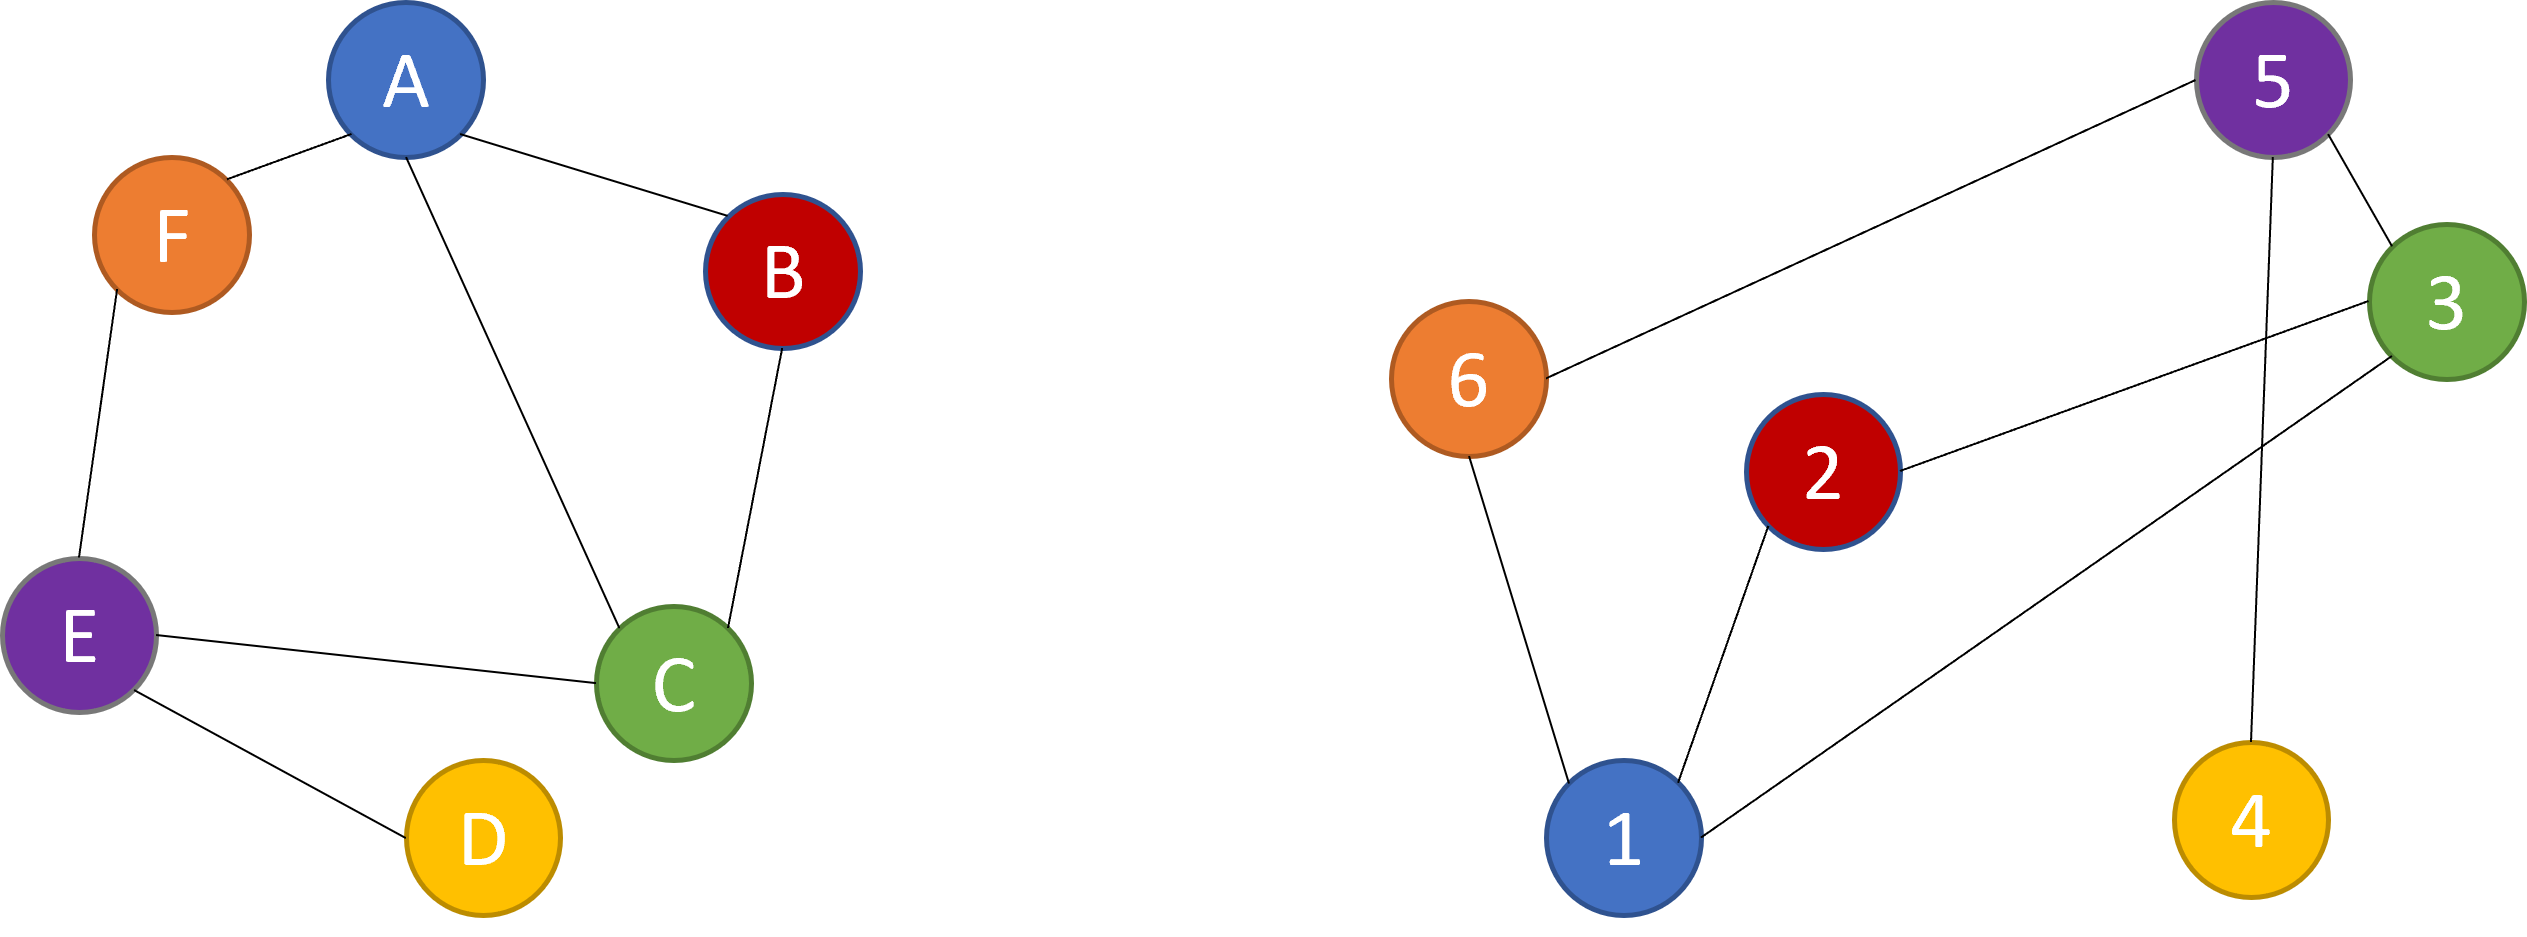

In [1]:
# Standard libraries
from collections import deque

# 3rd-party libraries
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import ggplot, aes

In [3]:
N = 1000  # Number of trees in simulation
M = 30  # Number of nodes in trees
MIN_SUBTREE_SIZE = 3  # Minimum number of nodes in subtrees
MIN_SUBTREE_FREQ = 2  # Minimum frequency of subtree

In [4]:
def collect_descendants(tree, node):
    """Return all of the descendants of a particular node (including self)."""
    nodes = set()
    nodes.add(node)
    searching = deque()
    searching.append(node)
    while len(searching):
        currentNode = searching.popleft()
        nodes.add(currentNode)
        for nextNode in tree.succ[currentNode].keys():
            searching.append(nextNode)
    return list(nodes)


def build_canonical_representations(tree, tree_ind, parent=0):
    """Return string representations of the unlabeled subtree structures."""
    global can_reps, subtree_locs
    children = tree.succ[parent].keys()
    if len(children):
        child_reps = []
        for child in children:
            child_reps.append(build_canonical_representations(tree, tree_ind, parent=child))
        child_reps.sort()
        new_rep = '(' + ''.join(child_reps) + ')'
        if len(new_rep)/2 >= MIN_SUBTREE_SIZE:
            can_reps.append(new_rep)
            subtree_locs.append((tree_ind, parent))
    else:
        new_rep = '()'
    return new_rep

In [5]:
# Simulate dataset
trees = [nx.random_tree(M, create_using=nx.DiGraph) for i in range(N)]

In [6]:
# Get bottom-up subtrees
can_reps = []  # Referenced globally by build_canonical_representations()
subtree_locs = []  # Referenced globally by build_canonical_representations()
for i, tree in enumerate(trees):
    build_canonical_representations(tree, i)
df = pd.DataFrame({'subtree_loc': subtree_locs, 'can_rep': can_reps})
grouped = df.groupby('can_rep', sort=False, as_index=False)
subtrees = grouped.agg(frequency=('can_rep', 'count'), sources=('subtree_loc', lambda x: list(x)))
subtrees = subtrees[subtrees['frequency'] >= MIN_SUBTREE_FREQ]
subtrees['size'] = (subtrees['can_rep'].str.len()//2)
subtrees.sort_values('size', inplace=True, ignore_index=True)

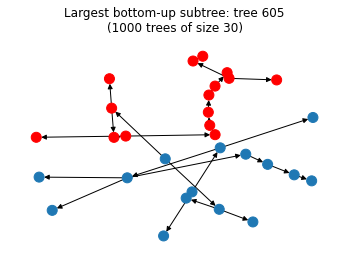

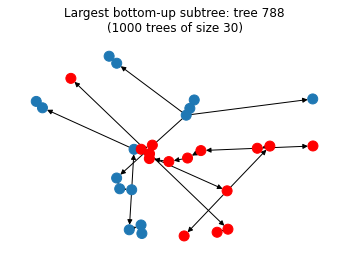

In [8]:
# Display biggest subtrees in context
biggest_locs = subtrees['sources'].iloc[-1]
for tree_ind, node_ind in biggest_locs:
    containing_tree = trees[tree_ind]
    #pos = graphviz_layout(containing_tree, prog='dot')  # Uncomment if graphviz working
    colors = np.full(M, '#1f78b4')
    subtree_nodes = collect_descendants(containing_tree, node_ind)
    colors[subtree_nodes] = '#ff0000'
    plt.figure()
    ax = plt.gca()
    ax.set_title(f"Largest bottom-up subtree: tree {tree_ind}\n({N} trees of size {M})")
    #nx.draw(containing_tree, pos=pos, node_color=colors, ax=ax, node_size=100)  # Uncomment if graphviz working
    nx.draw(containing_tree, node_color=colors, ax=ax, node_size=100)  # Comment if graphviz working
    plt.show()

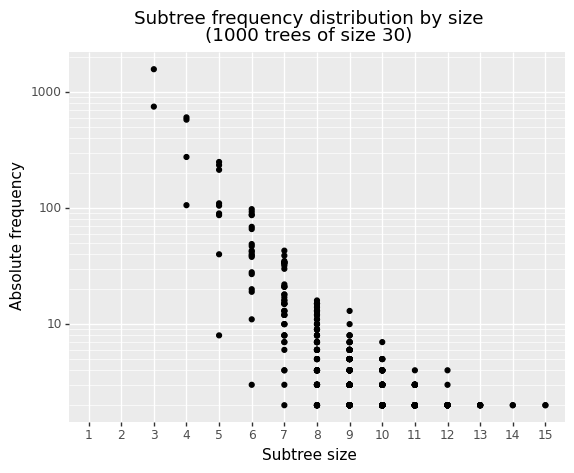

<ggplot: (171096377610)>

In [14]:
# Display plot of subtree frequency distribution by size
max_size = subtrees['size'].iloc[-1]
(
    ggplot(subtrees, aes(x='size', y='frequency')) +
    pn.geom_point() +
    pn.ggtitle(f"Subtree frequency distribution by size\n({N} trees of size {M})") +
    pn.labs(x="Subtree size", y="Absolute frequency") +
    pn.scale_x_discrete(limits=range(1, max_size+1)) +
    pn.scale_y_log10()
)

### Topologically sorted biggest trees (pre-saved)
(Couldn't install graphviz library in jupyter notebook.)

<div>
    <img src=attachment:tree_52.png width=450px align="left">
    <img src=attachment:tree_201.png width=450px align="right">
</div>
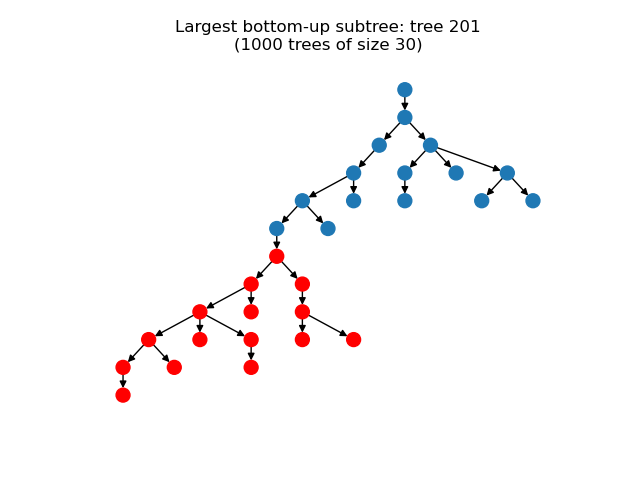
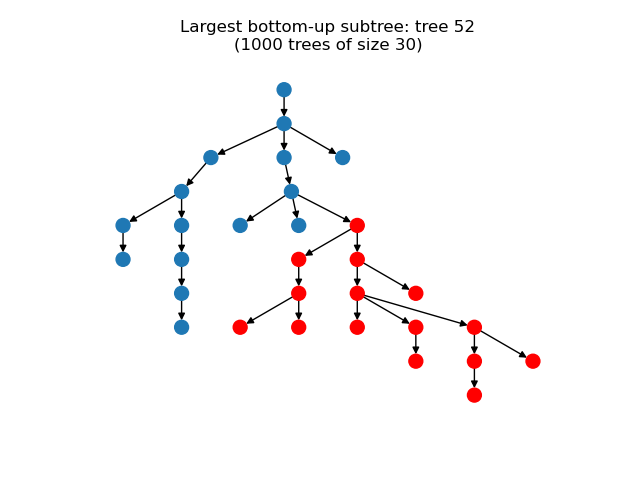

### Bottom-up subtree distribution (pre-saved)

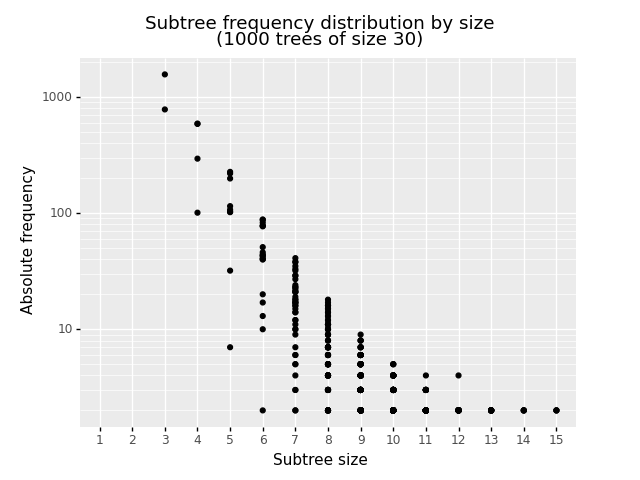

### REFERENCES
Review article by Chi et al (2005) ["Frequent Subtree Mining — An Overview"](http://www.csc.lsu.edu/~jianhua/frequent-survey.pdf)